In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [125]:
calls_df = pd.read_csv('/Users/sahilsharma/Desktop/Hackathon/callsf0d4f5a.csv')
customers_df = pd.read_csv('/Users/sahilsharma/Desktop/Hackathon/customers2afd6ea.csv')
reasons_df = pd.read_csv('/Users/sahilsharma/Desktop/Hackathon/reason18315ff.csv')
sentiment_stats_df = pd.read_csv('/Users/sahilsharma/Desktop/Hackathon/sentiment_statisticscc1e57a.csv')

In [148]:
calls_df.head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,handle_time,speed_to_answer
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,31.0,7.0
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,12.0,3.0
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,19.0,8.0
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,7.0,5.0
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,9.0,10.0


In [127]:
reasons_df.head()

,call_id,primary_call_reason
0,4667960400,Voluntary Cancel
1,1122072124,Booking
2,6834291559,IRROPS
3,2266439882,Upgrade
4,1211603231,Seating


In [128]:
customers_df.head()

,customer_id,customer_name,elite_level_code
0,2033123310,Matthew Foster,4.0
1,8186702651,Tammy Walters,NaN
2,2416856629,Jeffery Dixon,NaN
3,1154544516,David Wilkins,2.0
4,5214456437,Elizabeth Daniels,0.0


In [129]:
sentiment_stats_df.head()

,call_id,agent_id,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,963118,neutral,angry,-0.04,0.39
1,1122072124,519057,calm,neutral,0.02,0.35
2,6834291559,158319,neutral,polite,-0.13,0.32
3,2266439882,488324,neutral,frustrated,-0.20,0.20
4,1211603231,721730,neutral,polite,-0.05,0.35


In [130]:
print("Missing values in Calls Data:")
print(calls_df.isnull().sum())
print("Missing values in Customers Data:")
print(customers_df.isnull().sum())
print("Missing values in Reasons Data:")
print(reasons_df.isnull().sum())
print("Missing values in Sentiment Data:")
print(sentiment_stats_df.isnull().sum())


Missing values in Calls Data:
call_id                    0
customer_id                0
agent_id                   0
call_start_datetime        0
agent_assigned_datetime    0
call_end_datetime          0
call_transcript            0
dtype: int64
Missing values in Customers Data:
customer_id             0
customer_name           0
elite_level_code    25767
dtype: int64
Missing values in Reasons Data:
call_id                0
primary_call_reason    0
dtype: int64
Missing values in Sentiment Data:
call_id                      0
agent_id                     0
agent_tone                 217
customer_tone                0
average_sentiment          109
silence_percent_average      0
dtype: int64


In [131]:
# Step 1.2: Replace missing values with the mean for numerical columns and mode for categorical columns

# For the Calls Data
calls_df.fillna(calls_df.mean(numeric_only=True), inplace=True)
# For categorical columns, we'll use mode
calls_df.fillna(calls_df.mode().iloc[0], inplace=True)

# For the Customers Data
customers_df.fillna(customers_df.mean(numeric_only=True), inplace=True)
customers_df.fillna(customers_df.mode().iloc[0], inplace=True)

# For the Reasons Data
reasons_df.fillna(reasons_df.mode().iloc[0], inplace=True)

# For the Sentiment Data
sentiment_stats_df.fillna(sentiment_stats_df.mean(numeric_only=True), inplace=True)
sentiment_stats_df.fillna(sentiment_stats_df.mode().iloc[0], inplace=True)

In [132]:
# Convert datetime columns to proper datetime format
calls_df['call_start_datetime'] = pd.to_datetime(calls_df['call_start_datetime'])
calls_df['agent_assigned_datetime'] = pd.to_datetime(calls_df['agent_assigned_datetime'])
calls_df['call_end_datetime'] = pd.to_datetime(calls_df['call_end_datetime'])

In [149]:
# Calculate AHT (in minutes)
calls_df['handle_time'] = (calls_df['call_end_datetime'] - calls_df['agent_assigned_datetime']).dt.total_seconds() / 60.0

# Calculate AST (in minutes)
calls_df['speed_to_answer'] = (calls_df['agent_assigned_datetime'] - calls_df['call_start_datetime']).dt.total_seconds() / 60.0

In [150]:
# Step 1.4: Merge datasets as required for further analysis
merged_df_cleaned = calls_df.merge(reasons_df, on='call_id', how='left').merge(sentiment_stats_df, on='call_id', how='left')


merged_with_customers_df_cleaned = merged_df_cleaned.merge(customers_df, on='customer_id', how='left')




merged_with_customers_df_cleaned.head()



,call_id,customer_id,agent_id_x,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,handle_time,speed_to_answer,primary_call_reason,agent_id_y,agent_tone,customer_tone,average_sentiment,silence_percent_average,customer_name,elite_level_code
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,31.0,7.0,Voluntary Cancel,963118,neutral,angry,-0.04,0.39,Matthew Foster,4.000000
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,12.0,3.0,Booking,519057,calm,neutral,0.02,0.35,Tammy Walters,1.370871
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,19.0,8.0,IRROPS,158319,neutral,polite,-0.13,0.32,Jeffery Dixon,1.370871
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,7.0,5.0,Upgrade,488324,neutral,frustrated,-0.20,0.20,David Wilkins,2.000000
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,9.0,10.0,Seating,721730,neutral,polite,-0.05,0.35,Elizabeth Daniels,0.000000


/var/folders/lf/jf_r44ns23g_2jynyw40dvxm0000gn/T/ipykernel_10408/1441398915.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='primary_call_reason', y='handle_time', data=merged_with_customers_df_cleaned, ci=None)


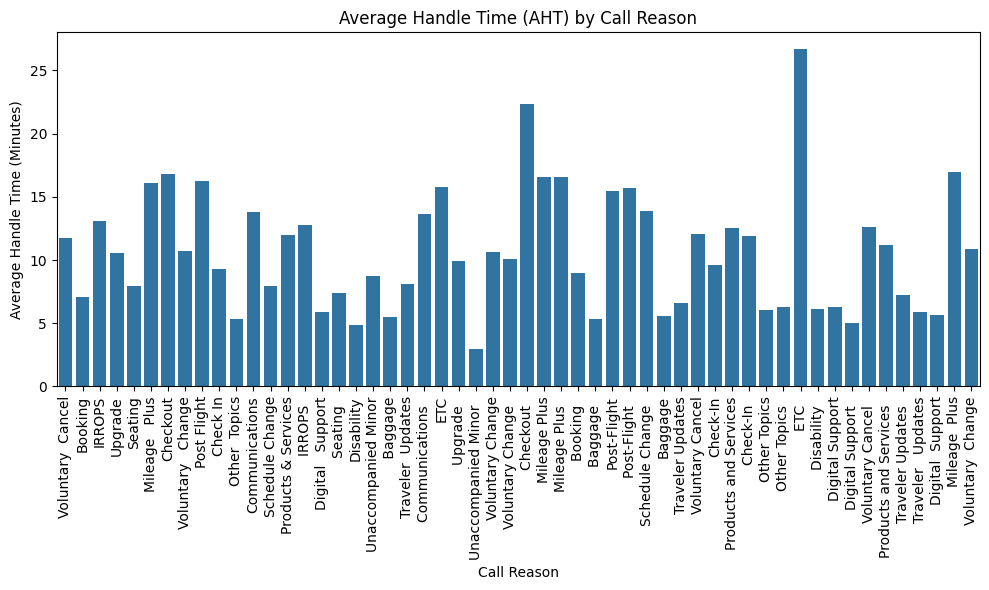

In [151]:
# Step 2: Visualizations
# handling time by Call Reason
plt.figure(figsize=(10, 6))
sns.barplot(x='primary_call_reason', y='handle_time', data=merged_with_customers_df_cleaned, ci=None)
plt.xticks(rotation=90)
plt.title('Average Handle Time (AHT) by Call Reason')
plt.xlabel('Call Reason')
plt.ylabel('Average Handle Time (Minutes)')
plt.tight_layout()
plt.show()

/var/folders/lf/jf_r44ns23g_2jynyw40dvxm0000gn/T/ipykernel_10408/1553014937.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='elite_level_code', y='speed_to_answer', data=loyalty_ast_cleaned, ci=None)


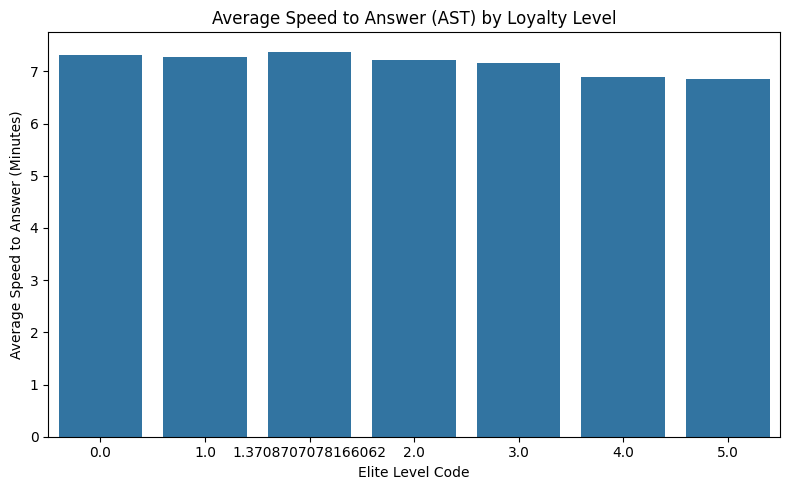

In [152]:
# speed to answere by Loyalty Level
loyalty_ast_cleaned = merged_with_customers_df_cleaned.groupby('elite_level_code')['speed_to_answer'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='elite_level_code', y='speed_to_answer', data=loyalty_ast_cleaned, ci=None)
plt.title('Average Speed to Answer (AST) by Loyalty Level')
plt.xlabel('Elite Level Code')
plt.ylabel('Average Speed to Answer (Minutes)')
plt.tight_layout()
plt.show()

/var/folders/lf/jf_r44ns23g_2jynyw40dvxm0000gn/T/ipykernel_10408/3766573958.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  silence_aht_cleaned = merged_df_cleaned.groupby(pd.cut(merged_df_cleaned['silence_percent_average'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1]))['handle_time'].mean().reset_index()
/var/folders/lf/jf_r44ns23g_2jynyw40dvxm0000gn/T/ipykernel_10408/3766573958.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='silence_percent_average', y='handle_time', data=silence_aht_cleaned, ci=None)


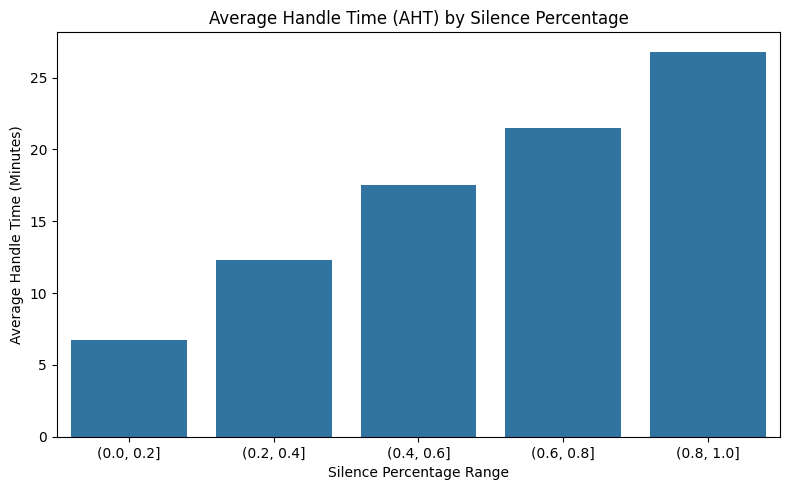

In [153]:
# handle time by Silence Percentage
silence_aht_cleaned = merged_df_cleaned.groupby(pd.cut(merged_df_cleaned['silence_percent_average'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1]))['handle_time'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='silence_percent_average', y='handle_time', data=silence_aht_cleaned, ci=None)
plt.title('Average Handle Time (AHT) by Silence Percentage')
plt.xlabel('Silence Percentage Range')
plt.ylabel('Average Handle Time (Minutes)')
plt.tight_layout()
plt.show()

In [154]:
# IVR Self-Service Potential: Frequent Call Reasons with Low AHT
potential_ivr_reasons_cleaned = merged_df_cleaned.groupby('primary_call_reason')['handle_time'].mean().reset_index()
ivr_reasons_cleaned = potential_ivr_reasons_cleaned[potential_ivr_reasons_cleaned['handle_time'] < 10]
ivr_reasons_cleaned

,primary_call_reason,handle_time
0,Baggage,5.488372
1,Baggage,5.574159
2,Baggage,5.338462
3,Booking,7.095017
4,Booking,8.958333
5,Check In,9.254545
6,Check-In,9.604698
12,Digital Support,5.911765
13,Digital Support,5.693333
14,Digital Support,6.305221


/var/folders/lf/jf_r44ns23g_2jynyw40dvxm0000gn/T/ipykernel_10408/3075302416.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='primary_call_reason', y='handle_time', data=ivr_reasons_cleaned, ci=None)


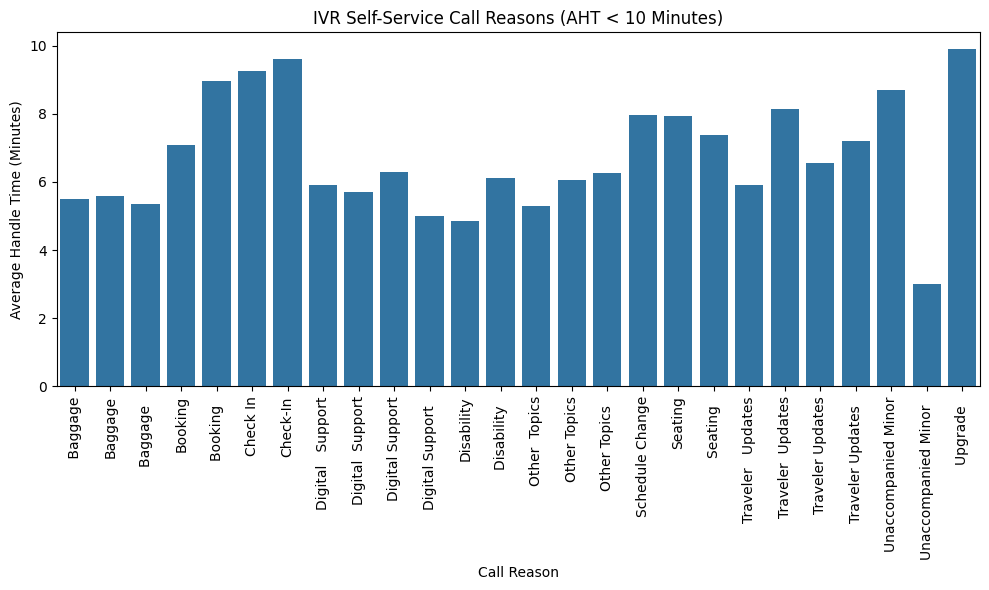

In [140]:



plt.figure(figsize=(10, 6))
sns.barplot(x='primary_call_reason', y='handle_time', data=ivr_reasons_cleaned, ci=None)
plt.xticks(rotation=90)
plt.title('IVR Self-Service Call Reasons (AHT < 10 Minutes)')
plt.xlabel('Call Reason')
plt.ylabel('Average Handle Time (Minutes)')
plt.tight_layout()
plt.show()

In [141]:
# Group by primary call reason to examine the average handle time (AHT)
reason_aht = merged_df_cleaned.groupby('primary_call_reason')['handle_time'].mean().reset_index()
print(reason_aht)



        primary_call_reason  handle_time
0                   Baggage     5.488372
1                   Baggage     5.574159
2                 Baggage       5.338462
3                   Booking     7.095017
4                 Booking       8.958333
5                  Check In     9.254545
6                  Check-In     9.604698
7                Check-In      11.896552
8                  Checkout    16.805978
9                Checkout      22.375000
10           Communications    13.780894
11         Communications      13.639344
12        Digital   Support     5.911765
13         Digital  Support     5.693333
14          Digital Support     6.305221
15        Digital Support       5.000000
16               Disability     4.840102
17             Disability       6.111111
18                      ETC    15.796774
19                    ETC      26.681818
20                   IRROPS    13.091522
21                 IRROPS      12.763780
22           Mileage   Plus    16.077519
23            Mi

In [142]:
# Group by agent/customer tone to examine their effect on AHT
tone_aht = merged_df_cleaned.groupby(['agent_tone', 'customer_tone'])['handle_time'].mean().reset_index()
print(tone_aht)



    agent_tone customer_tone  handle_time
0        angry         angry     8.298701
1        angry          calm     5.882353
2        angry    frustrated     6.500000
3        angry       neutral     5.787500
4        angry        polite     6.358974
5         calm         angry    10.273872
6         calm          calm    10.581906
7         calm    frustrated    10.491616
8         calm       neutral    10.464379
9         calm        polite    10.395363
10  frustrated         angry    10.510929
11  frustrated          calm    10.133527
12  frustrated    frustrated     9.640789
13  frustrated       neutral    10.902965
14  frustrated        polite    10.243101
15     neutral         angry    12.474535
16     neutral          calm    12.467828
17     neutral    frustrated    12.389962
18     neutral       neutral    12.710044
19     neutral        polite    12.298976
20      polite         angry     5.666667
21      polite          calm     2.294118
22      polite    frustrated     3

In [143]:

# Analyze the impact of silence percentage on AHT
silence_aht = merged_df_cleaned.groupby(pd.cut(merged_df_cleaned['silence_percent_average'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1]))['handle_time'].mean().reset_index()
print(silence_aht)

  silence_percent_average  handle_time
0              (0.0, 0.2]     6.741330
1              (0.2, 0.4]    12.283203
2              (0.4, 0.6]    17.486763
3              (0.6, 0.8]    21.481774
4              (0.8, 1.0]    26.805970


/var/folders/lf/jf_r44ns23g_2jynyw40dvxm0000gn/T/ipykernel_10408/259539826.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  silence_aht = merged_df_cleaned.groupby(pd.cut(merged_df_cleaned['silence_percent_average'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1]))['handle_time'].mean().reset_index()


In [144]:
# Analyze the most and least frequent call reasons
reason_frequencies = merged_df_cleaned['primary_call_reason'].value_counts().reset_index()
reason_frequencies.columns = ['primary_call_reason', 'call_count']

# Get the most frequent and least frequent call reasons
most_frequent_reason = reason_frequencies.iloc[0]['primary_call_reason']
least_frequent_reason = reason_frequencies.iloc[-1]['primary_call_reason']

# Calculate AHT for the most frequent and least frequent call reasons
most_frequent_aht = reason_aht[reason_aht['primary_call_reason'] == most_frequent_reason]['handle_time'].values[0]
least_frequent_aht = reason_aht[reason_aht['primary_call_reason'] == least_frequent_reason]['handle_time'].values[0]

# Calculate the percentage difference
percentage_difference = ((most_frequent_aht - least_frequent_aht) / least_frequent_aht) * 100
print(f"Percentage difference between most and least frequent call reasons: {percentage_difference:.2f}%")

Percentage difference between most and least frequent call reasons: 336.38%


In [145]:
# Analyze call reasons with relatively lower AHT and high call volumes to identify self-solvable issues
potential_ivr_reasons = reason_frequencies.merge(reason_aht, on='primary_call_reason', how='left')
potential_ivr_reasons = potential_ivr_reasons[(potential_ivr_reasons['handle_time'] < 10) & (potential_ivr_reasons['call_count'] > 100)]
print(potential_ivr_reasons)

    primary_call_reason  call_count  handle_time
2               Seating        6223     7.928812
8               Baggage        2616     5.574159
9               Booking        2589     7.095017
11             Check-In        1490     9.604698
13      Digital Support         996     6.305221
15     Traveler Updates         772     6.564767
16      Schedule Change         707     7.971711
17         Other Topics         568     6.044014
19           Disability         394     4.840102
20             Check In         385     9.254545
24        Other  Topics         234     5.299145
28            Seating           142     7.380282
29    Digital   Support         136     5.911765
31            Baggage           130     5.338462
33   Traveler   Updates         117     5.914530
34  Unaccompanied Minor         103     8.708738


In [146]:
# Look for common patterns in the transcripts for these reasons to identify recurring issues
recurring_problems = merged_df_cleaned[merged_df_cleaned['primary_call_reason'].isin(potential_ivr_reasons['primary_call_reason'])]
print(recurring_problems['call_transcript'].head())

1     \n\nAgent: Thank you for calling United Airlin...
4     \n\nAgent: Thank you for calling United Airlin...
14    \n\nAgent: Thank you for calling United Airlin...
15    \n\nAgent: Thank you for calling United Airlin...
18    \n\nAgent: Thank you for calling United Airlin...
Name: call_transcript, dtype: object


In [147]:
# Analyze the distribution of primary call reasons to identify the most common ones
call_reason_distribution = merged_df_cleaned['primary_call_reason'].value_counts()
print(call_reason_distribution)


primary_call_reason
IRROPS                     13057
Voluntary Change           10291
Seating                     6223
Mileage Plus                5487
Post-Flight                 3869
Communications              3779
Products and Services       2792
Upgrade                     2682
Baggage                     2616
Booking                     2589
Checkout                    1840
Check-In                    1490
Voluntary Cancel            1304
Digital Support              996
ETC                          930
Traveler Updates             772
Schedule Change              707
Other Topics                 568
Products & Services          476
Disability                   394
Check In                     385
Post Flight                  373
Voluntary  Cancel            278
IRROPS                       254
Other  Topics                234
Voluntary Change             208
Voluntary   Change           200
Voluntary  Change            149
Seating                      142
Digital   Support      

In [ ]:
# Import required libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Encode the target variable (call reasons) to numerical values using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(merged_df_cleaned['primary_call_reason'])

# Vectorize call transcripts using TF-IDF
tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(merged_df_cleaned['call_transcript']).toarray()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Logistic Regression model for multiclass classification
log_reg = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
log_reg.fit(X_train, y_train)

# Predict on test data
y_pred = log_reg.predict(X_test)

# Decode the predicted labels back to original call reason labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for Call Reason Categorization: {accuracy:.2f}")
print(classification_report(y_test, y_pred_decoded, target_names=label_encoder.classes_))
